In [3]:
import os, sys

sys.path.insert(0, "C:\\Users\\rudma\\Documents\\code\\mcsimpy\\src")

In [5]:
# Imports Gunnerus model
from mcsimpy.simulator.gunnerus import RVG_DP_6DOF
# Imports waves
from mcsimpy.waves import JONSWAP, WaveLoad

# Imports utilities
import numpy as np

In [6]:
dt = 0.01
simtime = 120
t = np.arange(0, simtime, dt)

vessel = RVG_DP_6DOF(dt=dt, method='RK4')

Uc = 0.0
beta_c = np.pi/4

eta = np.zeros((6, len(t)))
nu = np.zeros((6, len(t)))
tau_control = np.array([1000, 0, 0, 0, 0, 200000], dtype=float)

hs = 1.0 # Significant wave height
tp = 9.0 # Peak period
gamma = 1.3 # Peak factor
wp = 2*np.pi/tp # Peak frequency
wmin = 0.5*wp
wmax = 3.0*wp

N = 100 # Number of wave components

wave_freqs = np.linspace(wmin, wmax, N)

jonswap = JONSWAP(wave_freqs)

_, wave_spectrum = jonswap(hs=hs, tp=tp, gamma=gamma)

dw = (wmax - wmin) / N
wave_amps = np.sqrt(2 * wave_spectrum * dw)
rand_phase = np.random.uniform(0, 2*np.pi, size=N)
wave_angles = np.ones(N) * np.pi / 4

waveload = WaveLoad(
    wave_amps=wave_amps,
    freqs=wave_freqs,
    eps=rand_phase,
    angles=wave_angles,
    config_file=vessel._config_file,
    interpolate=True,
    qtf_method="geo-mean",      # Use geometric mean to approximate the QTF matrices.
    deep_water=True,            # Assume deep water conditions.
)

***************************************Generate QTF matrices****************************************
Using Geometric mean

***************************************QTF matrices complete.***************************************


Assign initial positions if necessery

In [7]:
eta_init = np.array([100, 100, 0, 0, 0, 0])
nu_init = np.zeros(6)

vessel.set_eta(eta_init)
vessel.set_nu(nu_init)

Run the simulation

In [8]:

for i in range(len(t)):
    tau_wave = waveload(t[i], vessel.get_eta())
    tau = tau_control + tau_wave
    eta[:, i] = vessel.get_eta()
    nu[:, i] = vessel.get_nu()
    vessel.integrate(Uc, beta_c, tau)



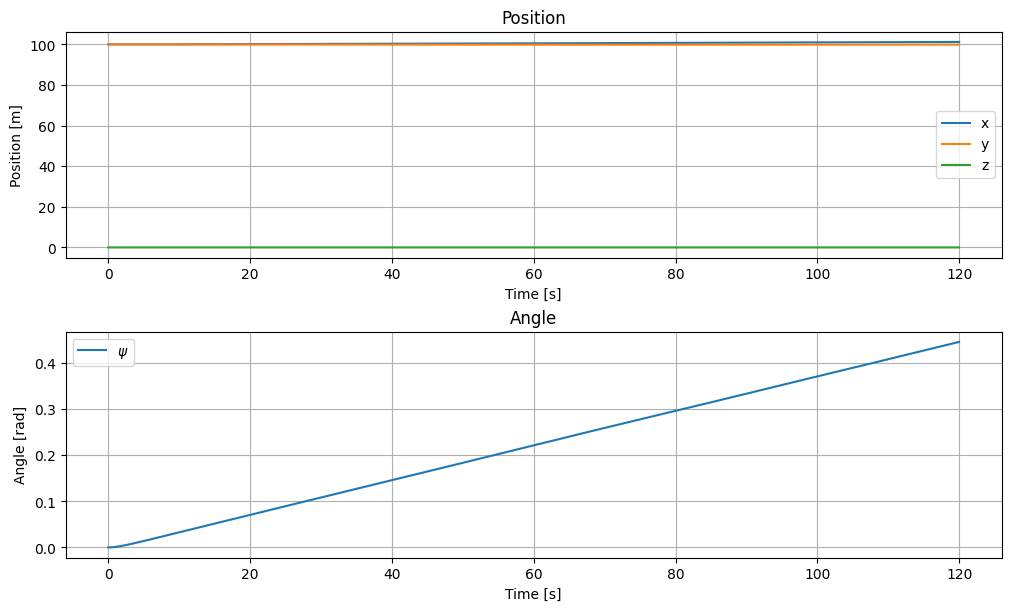

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), constrained_layout=True)
axes[0].plot(t, eta[0, :], label='x')
axes[0].plot(t, eta[1, :], label='y')
axes[0].plot(t, eta[2, :], label='z')
axes[0].legend()
axes[0].grid()
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Position [m]')
axes[0].set_title('Position')

axes[1].plot(t, eta[5, :], label=r"$\psi$")
axes[1].legend()
axes[1].grid()
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angle [rad]')
axes[1].set_title('Angle')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

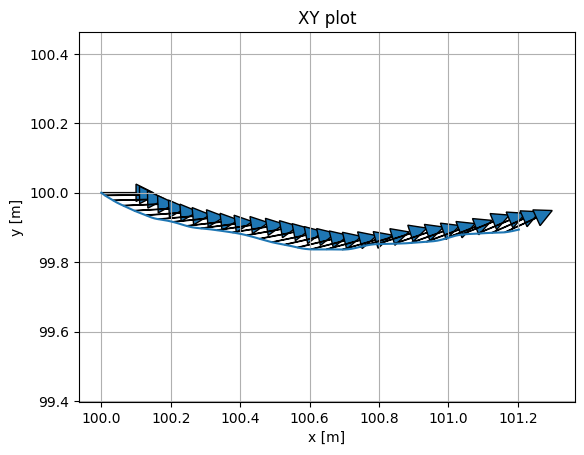

In [10]:
# Plot XY plot to position
plt.figure()
plt.plot(eta[0, :], eta[1, :])

# Plot orientation of the vessel described by arrows for every 30th time step
for i in range(0, len(t), 400):
    plt.arrow(eta[0, i], eta[1, i], 0.1* np.cos(eta[5, i]), 0.1*np.sin(eta[5, i]), head_width=0.05, head_length=0.05)


plt.axis('equal')
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('XY plot')
plt.show